In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
import pretrainedmodels
sys.path.append('../')
from fastai.vision import *
from modules.basics import *
from fastai.callbacks import *
np.random.seed(0)

# Data import

In [2]:
train_df = pd.read_csv(IMG_PATH/'train.csv'); len(train_df); train_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_lep_pz,PRI_tau_px,PRI_tau_py,PRI_tau_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight
0,0,0,209,236,74,0,0,0,219,79,...,230,151,124,73,59,82,152,0,0,0.000220
1,1,92,150,104,106,0,0,0,192,87,...,88,102,68,87,90,61,127,85,0,0.000068
2,2,0,195,111,113,0,0,0,105,94,...,137,181,126,92,48,171,169,85,0,0.000075
3,3,60,171,76,110,0,0,0,57,94,...,131,183,93,97,83,145,105,85,0,0.000075
4,4,0,184,60,74,0,0,0,45,80,...,73,189,87,78,56,104,152,0,0,0.000068


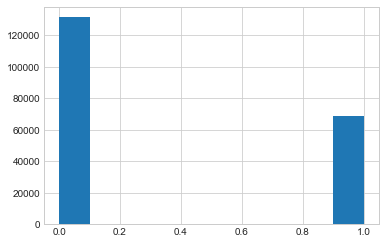

In [3]:
train_df.gen_target.hist()

In [4]:
len(train_df[train_df.gen_target==0])/len(train_df), len(train_df[train_df.gen_target==1])/len(train_df)

(0.65733, 0.34267)

In [5]:
size = 224

In [6]:
data = ImageDataBunch.from_df(df=train_df, label_col='gen_target', fn_col='image_name',
                              bs=20, ds_tfms=None, num_workers=8, valid_pct=0.2,
                              path=IMG_PATH/'pixel_images', folder='train', suffix='.png').normalize(imagenet_stats)

In [7]:
data

ImageDataBunch;

Train: LabelList (160000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,0
Path: /home/giles/Documents/kaggle/higgsml/pixel_images;

Valid: LabelList (40000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,1,0,0
Path: /home/giles/Documents/kaggle/higgsml/pixel_images;

Test: None

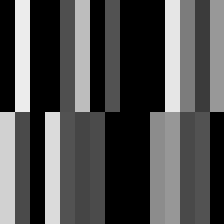

In [8]:
data.train_ds[0][0]

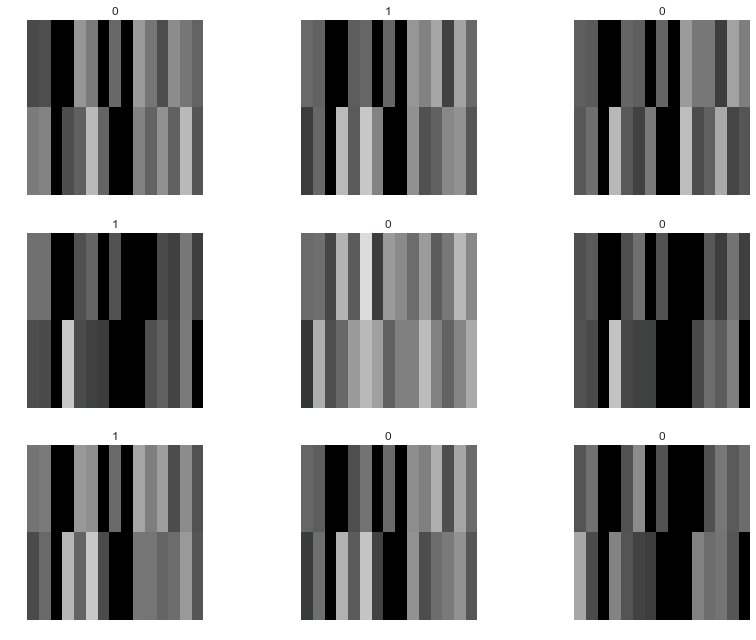

In [9]:
data.show_batch(rows=3, figsize=(12,9))

# Model training

In [8]:
def se_resnet154(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.senet154(pretrained=pretrained)
    return model

In [9]:
learn = cnn_learner(data, se_resnet154, pretrained=True, cut=-3, split_on=lambda m: (m[0][3], m[1]), metrics=error_rate)

In [12]:
learn.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu3): ReLU(inplace)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (1): Sequential(
      (0): SEBottleneck(
        (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runni

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


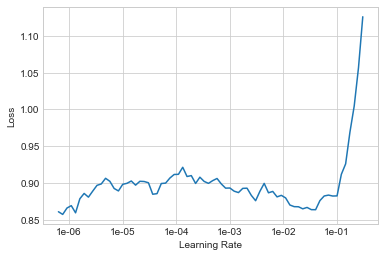

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(4, max_lr=1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.420686,0.445349,0.194425,1:12:10
1,0.433664,0.402487,0.172050,1:12:26
2,0.398389,0.371153,0.163550,1:12:06
3,0.368301,0.357984,0.159575,1:11:04


In [15]:
learn.save('stage-1')

In [10]:
learn.load('stage-1');

In [11]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


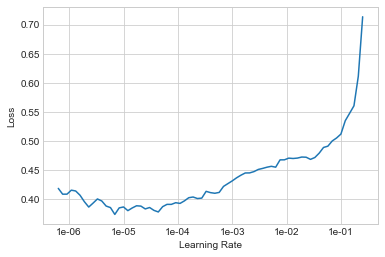

In [15]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,3e-5),
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='error_rate', name='best', mode='min')])

epoch,train_loss,valid_loss,error_rate,time
0,0.384374,0.361816,0.162550,1:42:46
1,0.379846,0.360753,0.159400,1:42:51
2,0.371540,0.356668,0.157650,1:42:51
3,0.356312,0.355256,0.156700,1:42:51


Better model found at epoch 0 with error_rate value: 0.16255000233650208.
Better model found at epoch 1 with error_rate value: 0.15940000116825104.
Better model found at epoch 2 with error_rate value: 0.15764999389648438.
Better model found at epoch 3 with error_rate value: 0.156700000166893.


In [13]:
learn.save('stage-2')

In [18]:
learn.load('stage-2');

In [19]:
learn.export()

## Interpretation

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9)

### Heatmap
Copied from https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson6-pets-more.ipynb

In [ ]:
x,y = data.valid_ds[1]

In [ ]:
m = learn.model.eval();

In [ ]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
from fastai.callbacks.hooks import *

In [ ]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts  = hook_a.stored[0].cpu()
acts.shape

In [ ]:
avg_acts = acts.mean(0)
avg_acts.shape

In [ ]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,size,size,0),
              interpolation='bilinear', cmap='magma');

In [ ]:
show_heatmap(avg_acts)

### Grad-CAM

In [ ]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

In [ ]:
mult = (acts*grad_chan[...,None,None]).mean(0)

In [ ]:
show_heatmap(mult)

# Inference

## Validation

In [20]:
val_df = pd.read_csv(IMG_PATH/'val.csv'); len(val_df); val_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_lep_pz,PRI_tau_px,PRI_tau_py,PRI_tau_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight
0,0,134,91,125,112,0,0,0,174,84,...,146,77,78,209,171,70,136,85,1,0.018636
1,1,101,117,103,114,93,99,157,163,84,...,90,94,91,101,126,194,109,170,1,0.001503
2,2,85,53,89,93,0,0,0,175,135,...,91,108,73,99,140,133,74,85,1,0.001503
3,3,152,74,165,131,0,0,0,138,132,...,87,104,152,73,149,108,89,85,1,0.018636
4,4,224,213,228,182,63,84,142,120,85,...,108,69,244,71,84,198,133,170,0,0.358540


In [21]:
val_lst = ImageList.from_df(val_df, IMG_PATH/'pixel_images', folder='val', suffix='.png')

In [22]:
learn = load_learner(IMG_PATH/'pixel_images', test=val_lst)

In [23]:
%%time
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

CPU times: user 6min 47s, sys: 31.8 s, total: 7min 19s
Wall time: 7min 10s


In [24]:
val_df['pred'] = to_np(multiclass2binary(preds))

/home/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


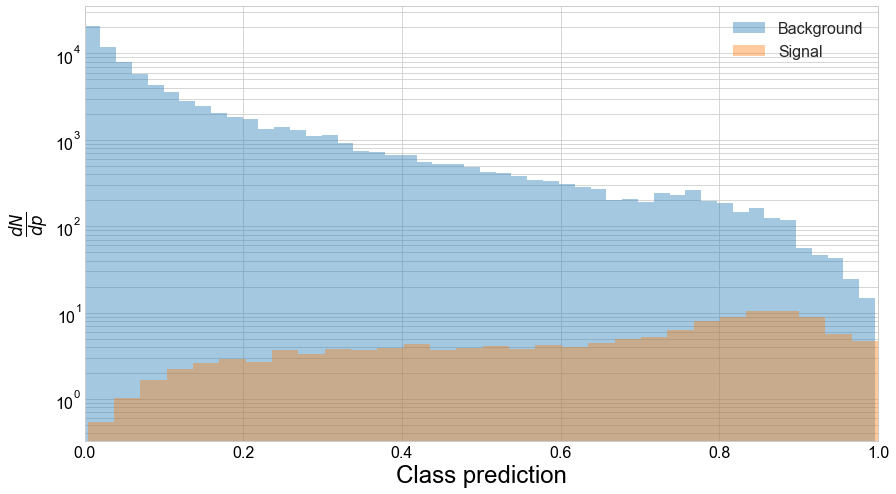

In [25]:
plot_binary_class_pred(val_df, wgt_name='gen_weight', density=False, log_y=True)

Mean cut at 0.8253610134124756 corresponds to AMS of 3.640973386526085
Maximum AMS for data is 3.7176936373576033 at cut of 0.8131414651870728


/home/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


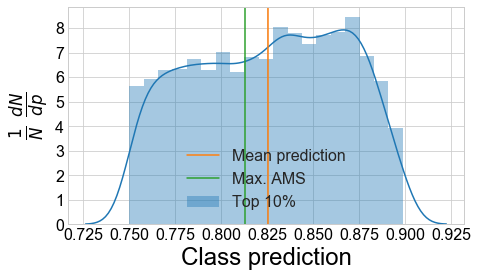

In [26]:
cut, smooth_ams, max_ams = binary_class_cut(val_df, top_perc=10, br=10, wgt_factor=250000/50000, min_pred=0.75)

## Test

In [44]:
test_df = pd.read_csv(IMG_PATH/'test.csv'); len(test_df); test_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_tau_px,PRI_tau_py,PRI_tau_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight,private
0,0,0,179,50,76,0,0,0,34,84,...,178,109,107,64,90,141,0,0,11.246676,0
1,1,0,179,43,89,0,0,0,23,124,...,195,75,137,57,154,150,0,0,2.452419,1
2,2,168,105,172,74,0,0,0,191,80,...,62,60,125,114,129,65,0,1,0.010415,1
3,3,78,146,101,142,0,0,0,63,86,...,222,84,113,104,51,129,85,0,1.117143,1
4,4,111,97,108,157,210,173,52,98,88,...,144,165,79,158,190,122,170,1,0.003789,0


In [45]:
test_lst = ImageList.from_df(test_df, IMG_PATH/'pixel_images', folder='test', suffix='.png')

In [46]:
learn = load_learner(IMG_PATH/'pixel_images', test=test_lst)

In [47]:
%%time
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

CPU times: user 1h 14min 39s, sys: 5min 50s, total: 1h 20min 30s
Wall time: 1h 18min 22s


In [48]:
test_df['pred'] = to_np(multiclass2binary(preds))

In [49]:
test_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_tau_py,PRI_tau_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight,private,pred
0,0,0,179,50,76,0,0,0,34,84,...,109,107,64,90,141,0,0,11.246676,0,0.006025
1,1,0,179,43,89,0,0,0,23,124,...,75,137,57,154,150,0,0,2.452419,1,0.004605
2,2,168,105,172,74,0,0,0,191,80,...,60,125,114,129,65,0,1,0.010415,1,0.592353
3,3,78,146,101,142,0,0,0,63,86,...,84,113,104,51,129,85,0,1.117143,1,0.034060
4,4,111,97,108,157,210,173,52,98,88,...,165,79,158,190,122,170,1,0.003789,0,0.898721


In [50]:
score_test_df(test_df, cut)

Public:Private AMS: 3.5010887673456517 : 3.4789749733651036


(3.5010887673456517, 3.4789749733651036)

In [11]:
score_test_df(test_df, 0.8057266)

Public:Private AMS: 3.4877109429895734 : 3.524155058845326


(3.4877109429895734, 3.524155058845326)

In [52]:
test_df.to_csv('5_test.csv')

In [7]:
test_df = pd.read_csv('5_test.csv')

In [8]:
test_df.head()

,Unnamed: 0,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_tau_py,PRI_tau_pz,PRI_met_px,PRI_met_py,PRI_met_pt,PRI_jet_num,gen_target,gen_weight,private,pred
0,0,0,0,179,50,76,0,0,0,34,...,109,107,64,90,141,0,0,11.246676,0,0.006025
1,1,1,0,179,43,89,0,0,0,23,...,75,137,57,154,150,0,0,2.452419,1,0.004605
2,2,2,168,105,172,74,0,0,0,191,...,60,125,114,129,65,0,1,0.010415,1,0.592353
3,3,3,78,146,101,142,0,0,0,63,...,84,113,104,51,129,85,0,1.117143,1,0.034060
4,4,4,111,97,108,157,210,173,52,98,...,165,79,158,190,122,170,1,0.003789,0,0.898721


In [17]:
from lumin.evaluation.ams import *
from sklearn.model_selection import StratifiedKFold

In [15]:
ams_scan_quick(test_df[test_df.private==0], br=10), ams_scan_quick(test_df[test_df.private==1], br=10)

((3.4969933641539206, 0.82534593), (3.522287450113049, 0.80384743))

In [64]:
def subsample_score_test(df:pd.DataFrame, cut:Optional[float]=None):
    amss = pd.DataFrame(columns=['Public_AMS', 'Private_AMS', 'Public_Cut', 'Private_Cut'])
    skf = KFold(10, True, 0)
    folds = skf.split(df)
    for _, fold in folds:
        test_fold = test_df.iloc[fold]
        if cut is None:
            public_ams, public_cut = ams_scan_quick(test_fold[test_fold.private==0], br=10, wgt_factor=len(test_df[test_df.private==0])/len(test_fold[test_fold.private==0]))
            private_ams, private_cut = ams_scan_quick(test_fold[test_fold.private==1], br=10, wgt_factor=len(test_df[test_df.private==1])/len(test_fold[test_fold.private==1]))
        else:
            public_cut,private_cut = cut,cut 
            public_ams, private_ams = score_test_df(test_fold, cut, verbose=False,
                                                    public_wgt_factor=len(test_df[test_df.private==0])/len(test_fold[test_fold.private==0]),
                                                    private_wgt_factor=len(test_df[test_df.private==1])/len(test_fold[test_fold.private==1]))
        amss = amss.append({'Public_AMS':public_ams, 'Private_AMS':private_ams, 'Public_Cut':public_cut, 'Private_Cut':private_cut}, ignore_index=True)
    return amss

In [65]:
results = subsample_score_test(test_df); results

,Public_AMS,Private_AMS,Public_Cut,Private_Cut
0,3.732838,3.570506,0.927892,0.765832
1,3.818891,3.724701,0.754688,0.804445
2,3.575463,3.553739,0.856989,0.805499
3,4.002111,3.870061,0.803874,0.834065
4,3.697073,3.395779,0.825583,0.799577
5,5.793222,3.588204,0.943507,0.819754
6,5.224085,3.472492,0.972227,0.811540
7,3.629787,3.551440,0.672828,0.844292
8,3.549377,3.631985,0.813894,0.792382
9,4.356540,3.541355,0.853358,0.803823


In [66]:
results.describe()

,Public_AMS,Private_AMS,Public_Cut,Private_Cut
count,10.000000,10.000000,10.000000,10.000000
mean,4.137939,3.590026,0.842484,0.808121
std,0.772239,0.131412,0.090521,0.021798
min,3.549377,3.395779,0.672828,0.765832
25%,3.646608,3.543876,0.806379,0.800638
50%,3.775864,3.562123,0.839471,0.804972
75%,4.267933,3.621040,0.910166,0.817701
max,5.793222,3.870061,0.972227,0.844292


In [67]:
results = subsample_score_test(test_df, cut=0.8131414651870728); results

,Public_AMS,Private_AMS,Public_Cut,Private_Cut
0,3.498149,3.391813,0.813141,0.813141
1,3.699343,3.660001,0.813141,0.813141
2,3.319960,3.496539,0.813141,0.813141
3,3.941332,3.674846,0.813141,0.813141
4,3.601791,3.335822,0.813141,0.813141
5,3.027416,3.536567,0.813141,0.813141
6,3.433112,3.430861,0.813141,0.813141
7,3.360778,3.409788,0.813141,0.813141
8,3.515428,3.544893,0.813141,0.813141
9,3.383671,3.498886,0.813141,0.813141


In [68]:
results.describe()

,Public_AMS,Private_AMS,Public_Cut,Private_Cut
count,10.000000,10.000000,10.000000,10.000000
mean,3.478098,3.498002,0.813141,0.813141
std,0.243461,0.111093,0.000000,0.000000
min,3.027416,3.335822,0.813141,0.813141
25%,3.366501,3.415056,0.813141,0.813141
50%,3.465631,3.497712,0.813141,0.813141
75%,3.580201,3.542811,0.813141,0.813141
max,3.941332,3.674846,0.813141,0.813141
